# S2W5D1: 输入层 - 赋予模型“语义”与“位置”感

在深度学习中，计算机只能处理数字。Transformer的第一步，就是要把人类理解的“**字（Token）**”转换成计算机理解的“**向量（Vector）**”，并且告诉它“**顺序（Order）**”。

## 1 词嵌入（Word Embedding）：语义的容器

**Embedding 层**的原理：
 - **原理**：一个巨大的查找表（Lookup Table）。每一行代表一个词，每一列代表一个特征维度。
 - **代码对应**：`nn.Embedding(vocab_size, d_model)`
    - `vocab_size`：词表大小（比如30000个常用词）。
    - `d_model`：嵌入维度（Transformer论文中是514）。

In [5]:
import torch
import torch.nn as nn

# 假设词表只有 10 个词，每个词用 4 维向量表示
embedding_layer = nn.Embedding(num_embeddings=10, embedding_dim=4)

# 输入一个batch，包含2个句子，每个句子3个词（索引）
input_ids = torch.tensor([[1, 2, 3], [4, 5, 6]]) #  Shape: [2, 3]

# 查表
output = embedding_layer(input_ids)
print("Input Shape:", input_ids.shape) # [Batch=2, Seq_Len=3]
print("Output Shape:", output.shape)   # [Batch=2, Seq_Len=3, Dim=4]


Input Shape: torch.Size([2, 3])
Output Shape: torch.Size([2, 3, 4])


## 2 位置编码 (Positional Encoding): 注入灵魂

这是Transformer最天才的设计之一。

### 2.1 作用

RNN（循环神经网络）是按顺序读句子的（先读“我”，再读“爱”，在读“你”），所以它天然知道位置信息。但是Transformer的Attention机制是并行的，它一眼看完整个句子。如果没有任何位置信息，“我爱你”和“你爱我”在Attention看来是完全一样的（都是这三个字的组合）。所以我们需要人为的把“**位置信息**”添加到Embedding里面去。

### 2.2 如何添加

Transformer原论文使用了一组**正弦Sin**和**余弦Cos**函数来生成位置向量。对于句子中第$pos$个位置的词，它的第$2i$和$2i+1$个维度的编码公式如下：

$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}})$$

    - $pos$: 词在句子中的位置 (0, 1, 2, ...)。
    - $i$: 向量维度的索引。
    - $d_{model}$: 模型的总维度 (512)。

**直观理解**：
想象一下时钟。

  * 秒针转得快 (高频)：代表维度的低位，变化剧烈。
  * 分针转得慢 (低频)：代表维度的高位，变化缓慢。
  * 通过不同频率的 Sin/Cos 组合，每个位置 $pos$ 都能获得一个**独一无二**的纹理特征。

## 3 核心代码实现（Hand-Written Implementation）

以下是位置编码的核心代码实现

In [ ]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Args:
            d_model: 模型的维度 (通常是 512)
            max_len: 预设的最大序列长度 (防止输入句子太长)
        """
        super(PositionalEncoding, self).__init__()

        # 1. 创建一个矩阵 pe，大小是 [max_len, d_model]，初始化为 0
        pe = torch.zeros(max_len, d_model)

        # 2. 生成位置索引pos: [0, 1, 2, ..., max_len - 1] -> Shape: [max_len, 1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # 3. 计算分母中的 div_term: 10000^(2i/d_model)
        # 这里的数学变换利用了 log: exp(log(x)) = x
        # 这是为了数值稳定性，防止分母溢出
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # 4. 填充矩阵
        # 偶数维度用 sin
        pe[:, 0::2] = torch.sin(position * div_term)
        # 奇数维度用 cos
        pe[:, 1::2] = torch.cos(position * div_term)

        # 5. 增加一个维度，使其适配 Batch: [max_len, d_model] -> [1, max_len, d_model]
        # 这样在加法时，可以利用广播机制 (Broadcasting) 应用到所有 Batch 上
        pe = pe.unsqueeze(0)

        # 6. 注册为 buffer
        # 这是一个关键点！
        # register_buffer 告诉 PyTorch: "这个变量不是模型参数(不需要梯度更新)，
        # 但是它是模型状态的一部分，保存模型(save_state_dict)时要把它带上。"
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        x: [batch_size, seq_len, d_model]
        """
        # x 的长度可能小于 max_len，所以我们要切片
        # x + pe[:x.size(1)] 利用了广播机制
        # [batch, seq, d] + [1, seq, d] -> [batch, seq, d]
        x = x + self.pe[:, :x.size(1), :]
        return x
    
# --- 测试代码 ---
# 模拟参数
d_model = 512
max_len = 100
input_embedding = torch.randn(32, max_len, d_model) # Batch=32

# 实例化
pe_layer = PositionalEncoding(d_model=d_model, max_len=max_len)

# 前向传播
output = pe_layer(input_embedding)

print("Input shape:", input_embedding.shape)
print("PE shape (internal):", pe_layer.pe.shape)
print("Output shape:", output.shape) # 应该保持不变

Input shape: torch.Size([32, 100, 512])
PE shape (internal): torch.Size([1, 100, 512])
Output shape: torch.Size([32, 100, 512])


## 4 可视化验证 (Debug like a Pro)

可以通过画图来理解频率变化

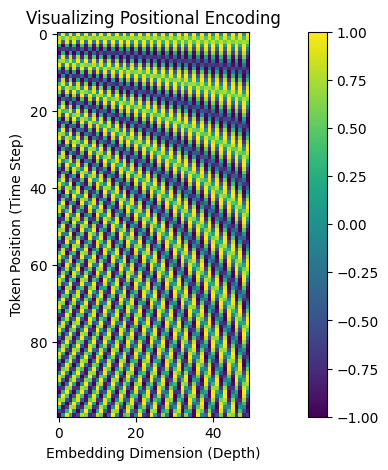

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
# 去除pe的第一个batch（因为它全是复制的），截取前100个位置，前50个维度
pe_matrix = pe_layer.pe[0, :100, :50].numpy()

plt.imshow(pe_matrix, cmap='viridis')
plt.xlabel('Embedding Dimension (Depth)')
plt.ylabel('Token Position (Time Step)')
plt.colorbar()
plt.title("Visualizing Positional Encoding")
plt.show()

**观察**: 可以看到左边（低维度）纹理波动很快（高频），右边（高维度）颜色变化很慢（低频）。这就是正弦波在起作用。

## 5 面试八股文与具身迁移 (Interview & Robotics)

### 5.1 面试官会问什么？

1.  **Q: 为什么要相加 (`x + pe`) 而不是拼接 (`concat(x, pe)`)？**

      * **A**:
          * **维度效率**: 拼接会增加维度，导致后续参数量增加。
          * **数学性质**: 相加保留了 Embedding 的分布特征。而且数学上可以证明，相加包含的信息量和拼接是等价的（只是混合在了一起，网络可以学会把它们拆开）。

2.  **Q: 为什么要用 Sin/Cos 这种正弦函数？为什么不直接训练一个 Embedding？**

      * **A (标准答案)**:
          * **外推性 (Extrapolation)**: 如果训练时最大长度是 100，测试时遇到了长度 120 的句子，Sin/Cos 函数可以直接计算出第 120 个位置的编码。而如果是训练出来的 Embedding (`nn.Embedding`)，第 120 个位置就是未知的（越界了）。
          * **相对位置信息**: 正弦函数有个性质：$PE(pos+k)$ 可以表示为 $PE(pos)$ 的线性变换。这意味着模型更容易学到“相对距离”的关系（比如单词 A 在单词 B 后面第 3 个位置）。

3.  **Q: `register_buffer` 是什么？**

      * **A**: 它是 `nn.Module` 的一个方法，用于注册那些“不是参数（不需要梯度下降）”但“需要随模型保存和加载”的张量。PE 矩阵就是典型的 buffer。

### 5.2 具身智能视角 (Embodied AI)

作为机器人项目负责人，你需要这样理解 PE：

  * **轨迹规划**: 在 Transformer 控制机器臂时 (例如 Action Chunking)，你输入的不是句子，而是过去 10 帧的**关节状态**。如果不加 PE，机器人就不知道哪一帧是“前一秒”，哪一帧是“现在”。这里的 PE 代表了**时间 (Time)**。
  * **ViT (视觉)**: 当机器人看图时，图片被切成 16x16 的块。如果不加 PE，机器人就不知道哪个块是“左上角”，哪个是“右下角”。这里的 PE 代表了**空间 (Space)**。

## 🚀 今日任务 (Action Items)

1.  **代码复现**: 不要复制粘贴，请手动敲一遍 `PositionalEncoding` 类，尤其是计算 `div_term` 的那一行。
2.  **运行可视化**: 跑通热力图，盯着它看 10 秒，理解这种“频率纹理”。
3.  **思考**: 如果我要做**2D 图像**的位置编码（有 x 轴和 y 轴），这套公式该怎么改？（提示：分别为 x 和 y 生成编码，然后拼接或相加）。

## 今日练习

### 1. 【矩阵思维】LeetCode 48. 旋转图像 (Rotate Image)
* **难度**: Medium
* **链接**: [旋转图像 (Rotate Image)](../../LeetCode%20practice/1-50.ipynb)
* **为什么选这道题**:
    * **核心关联**: 今天我们在 2D 位置编码的思考题中讨论了 X 轴和 Y 轴的处理。这道题要求你把一个二维矩阵顺时针旋转 90 度。
    * **CV/具身应用**: 在做图像数据增强（Data Augmentation）时，经常需要旋转图片。理解索引 `(i, j)` 如何变换到 `(j, n-1-i)` 是处理图像 tensor 的基本功。
    * **挑战**: 必须 **原地 (In-place)** 修改，不能新建矩阵。这考验你对索引的控制力。

### 2. 【NLP 预处理】LeetCode 151. 反转字符串中的单词 (Reverse Words in a String)
* **难度**: Medium
* **链接**: [反转字符串中的单词 (Reverse Words in a String)](../../LeetCode%20practice/151-200.ipynb)
* **为什么选这道题**:
    * **核心关联**: Transformer 的输入是 Token 序列。这道题通过空格分割单词、反转顺序、再拼接，涵盖了 NLP 数据清洗中最常用的 `strip()`, `split()`, `join()` 操作。
    * **面试高频**: 字节跳动、微软非常喜欢考这道题，因为它能瞬间测出你对 Python 字符串 API 的熟练度（或者手写 split 的能力）。
    * **技巧**: 试着一行代码解决（Pythonic 写法），也试着不使用内置函数解决（算法写法）。

### 3. 【左右上下文】LeetCode 238. 除自身以外数组的乘积 (Product of Array Except Self)
* **难度**: Medium
* **链接**: [除自身以外数组的乘积 (Product of Array Except Self)](../../LeetCode%20practice/201-250.ipynb)
* **为什么选这道题**:
    * **核心关联**: 题目要求 `O(n)` 且不能用除法。解法的核心是**“前缀积”**和**“后缀积”**。
    * **深度学习映射**: 这非常有意思，它体现了 **“双向上下文”** 的思想。
        * 计算位置 `i` 的结果，需要它 **左边所有数** 的乘积（Past Context）和 **右边所有数** 的乘积（Future Context）。
        * 这和 **BERT**（双向 Transformer）同时看左边和右边的上下文有着异曲同工之妙。